In [ ]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from pathlib import Path
import os.path
from distutils.dir_util import copy_tree, remove_tree
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
import time

from PIL import Image
from random import randint

from sklearn.metrics import classification_report, confusion_matrix
import itertools



from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 

from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50


import scipy
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)
warnings.simplefilter('ignore')

In [ ]:
aug_data = "C:/Users/ssahoo/Downloads/dataseet/AugmentedAlzheimerDataset"
org_data = "C:/Users/ssahoo/Downloads/dataseet/OriginalDataset"

In [3]:
image_dir = Path(aug_data)

filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) 
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [4]:
def get_dataset(augmented = 0):
    if(augmented == 0):
        image_dir = Path(org_data)
    else:
        image_dir = Path(aug_data)
    
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) 
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df
        

In [5]:
train_df = get_dataset(1)
test_df = get_dataset(0)

In [ ]:
pd.set_option('display.max_colwidth', None)
train_df.head()

In [ ]:
test_df.tail()

# Random 25 pictures for Augmented Samples and Original Samples

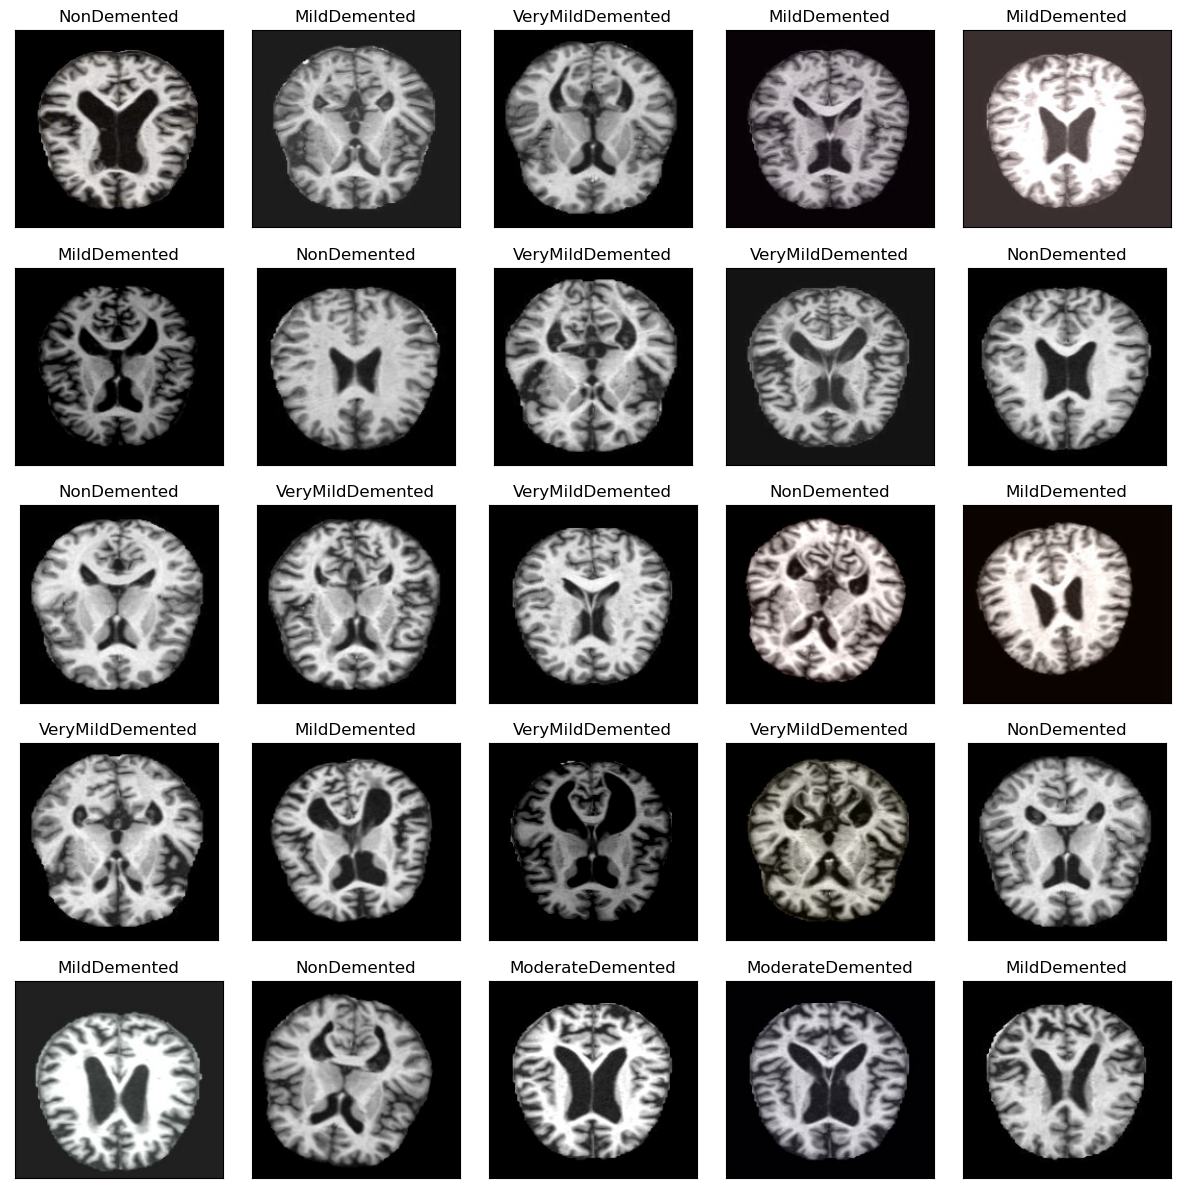

In [8]:
random_index = np.random.randint(0, len(train_df), 25)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(plt.imread(train_df.Filepath[random_index[i]]), cv2.COLOR_BGR2RGB))
    ax.set_title(train_df.Label[random_index[i]])
plt.tight_layout()
plt.savefig("Augmented.pdf")

plt.show()

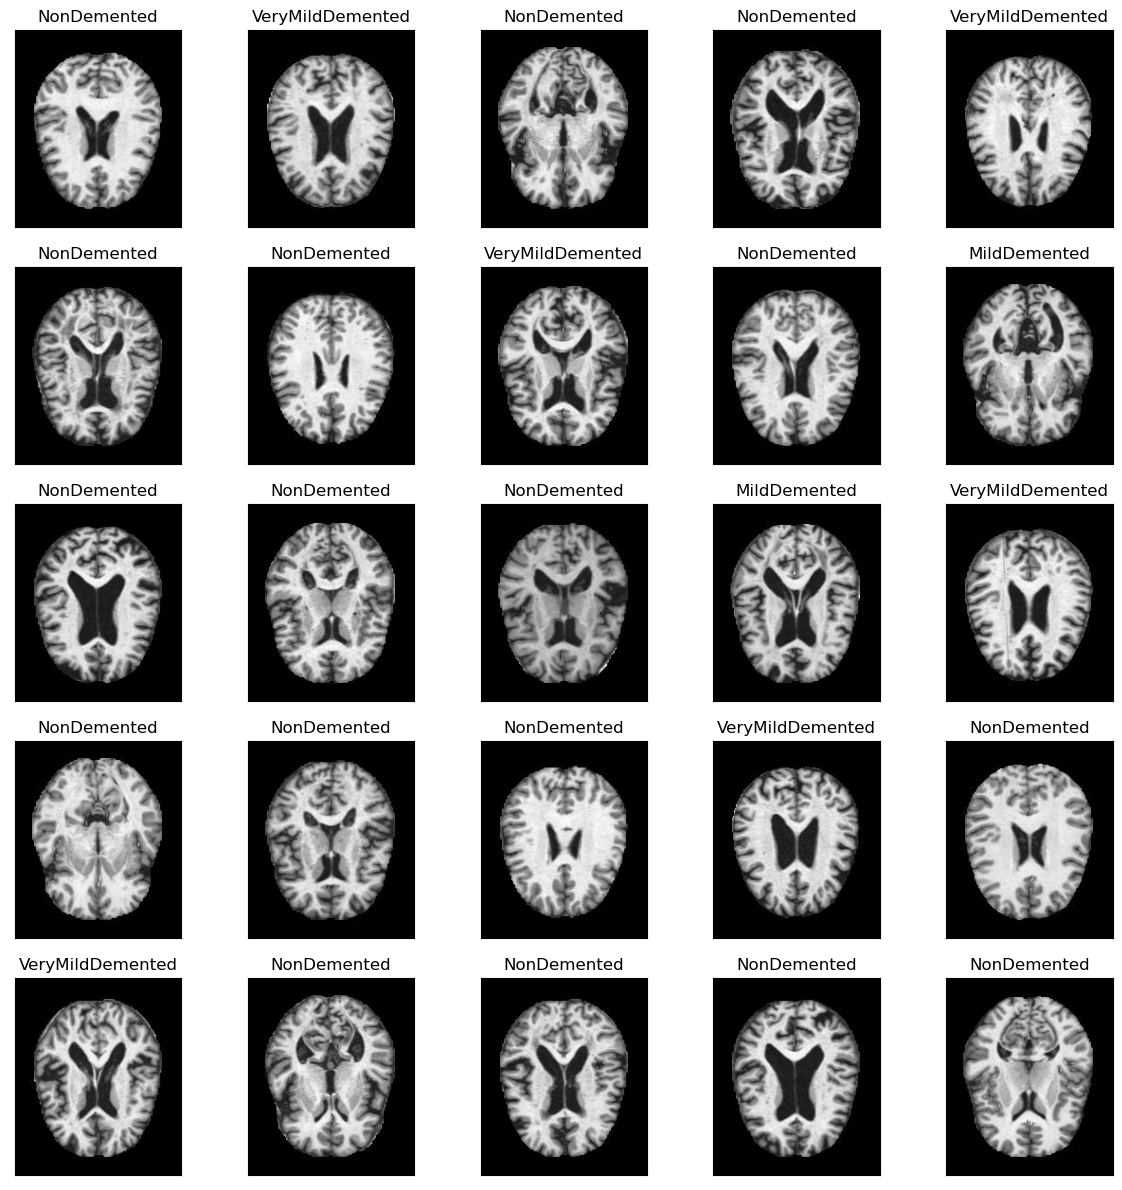

In [9]:
# Displaying 25 picture of the original dataset with their labels
random_index = np.random.randint(0, len(test_df), 25)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(plt.imread(test_df.Filepath[random_index[i]]), cv2.COLOR_BGR2RGB))
    ax.set_title(test_df.Label[random_index[i]])
plt.tight_layout()
plt.savefig("Original.pdf")
plt.show()

In [10]:
print("Train data set label distribution:\n",train_df.Label.value_counts())

print("\nTest data set label distribution:\n", test_df.Label.value_counts())

Train data set label distribution:
 Label
NonDemented         19200
MildDemented        17920
VeryMildDemented    17920
ModerateDemented    12928
Name: count, dtype: int64

Test data set label distribution:
 Label
NonDemented         6400
VeryMildDemented    4480
MildDemented        1792
ModerateDemented     128
Name: count, dtype: int64


In [11]:
base_dir = "/C:/Users/ssahoo/Downloads/dataseet/"
root_dir = "./"
train_dir = base_dir / "AugmentedAlzheimerDataset"
test_dir = base_dir / "OriginalDataset"

In [12]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [13]:
import os

train_dir = r"C:\Users\ssahoo\Downloads\dataseet\AugmentedAlzheimerDataset"  # Use a raw string

if not os.path.exists(train_dir):
    print(f"Error: The directory '{train_dir}' does not exist.")
else:
    print("Directory found! Proceeding with data loading.")
    


Directory found! Proceeding with data loading.


In [14]:
test_dir = "C:/Users/ssahoo/Downloads/dataseet/OriginalDataset"

import os

if not os.path.exists(test_dir):
    print(f"Error: The directory '{test_dir}' does not exist.")
else:
    print("Directory found! Proceeding with data loading.")


Directory found! Proceeding with data loading.


In [15]:
datagen = IDG(rescale = 1./255, validation_split=0.1)

train_gen = datagen.flow_from_directory(directory=train_dir,
                                             target_size=DIM,
                                             batch_size=400,
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True)

validation_gen = datagen.flow_from_directory(directory=train_dir,
                                             target_size=DIM,
                                             batch_size=400,
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=True)

test_gen = datagen.flow_from_directory(directory=test_dir,
                                             target_size=DIM,
                                             batch_size=6400,
                                             class_mode='categorical')

Found 30586 images belonging to 4 classes.
Found 3398 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [16]:
test_gen_plot = datagen.flow_from_directory(directory=test_dir,
                                             target_size=DIM,
                                             batch_size=128,
                                             class_mode='categorical')

Found 6400 images belonging to 4 classes.


In [17]:
def prepare_for_test(model, test_gen):
    data, y_true = test_gen.next()
    y_pred_ = model.predict(data, batch_size = 64)
    y_pred = []
    for i in range(y_pred_.shape[0]):
        y_pred.append(np.argmax(y_pred_[i]))
        
    y_true = np.argmax(y_true, axis=1)
    
    return y_true, y_pred

----

# ResNet50

In [18]:
rn = ResNet50(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in rn.layers:
    layer.trainable = False
x = Flatten()(rn.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=rn.input, outputs=prediction)

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=70, callbacks=callback)

toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

Epoch 1/70
77/77 ━━━━━━━━━━━━━━━━━━━━ 975s 12s/step - acc: 0.2961 - auc: 0.5393 - loss: 4.5880 - val_acc: 0.5589 - val_auc: 0.8021 - val_loss: 1.0916
Epoch 2/70
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/70
77/77 ━━━━━━━━━━━━━━━━━━━━ 978s 12s/step - acc: 0.5438 - auc: 0.7986 - loss: 1.0798 - val_acc: 0.6024 - val_auc: 0.8433 - val_loss: 0.9877
Epoch 4/70
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - acc: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/70
77/77 ━━━━━━━━━━━━━━━━━━━━ 877s 11s/step - acc: 0.5812 - auc: 0.8309 - loss: 0.9985 - val_acc: 0.5541 - val_auc: 0.8260 - val_loss: 0.9888
Epoch 6/70
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - acc: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/70
77/77 ━━━━━━━━━━━━━━━━━━━━ 887s 11s/step - acc: 0.5975 - auc: 0.8452 - loss: 0.9450 - val_acc: 0.5038 - val_auc: 0.8107 - val_loss: 1.0354
Epoch 8/70
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - acc: 0.0000e+00 - auc: 0.00

In [19]:
results = model.evaluate(train_gen)

if len(results) == 2:
    train_loss, train_accuracy = results
    print(f'\nTrain loss: {train_loss:.2f}')
    print(f'Train Accuracy: {train_accuracy*100:.2f} %')
else:
    print(f'\nTrain results: {results}')

77/77 ━━━━━━━━━━━━━━━━━━━━ 735s 10s/step - acc: 0.8008 - auc: 0.9580 - loss: 0.5191

Train results: [0.5213280916213989, 0.957401692867279, 0.798306405544281]


In [20]:

results = model.evaluate(validation_gen)

if len(results) == 2:
    train_loss, train_accuracy = results
    print(f'\nValidation loss: {train_loss:.2f}')
    print(f'Validation Accuracy: {train_accuracy*100:.2f} %')
else:
    print(f'\nValidation results: {results}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 78s 9s/step - acc: 0.7638 - auc: 0.9416 - loss: 0.5865

Validation results: [0.5806005001068115, 0.9429217576980591, 0.7633902430534363]


In [21]:

results = model.evaluate(test_gen_plot)

if len(results) == 2:
    train_loss, train_accuracy = results
    print(f'\nTest loss: {train_loss:.2f}')
    print(f'Test Accuracy: {train_accuracy*100:.2f} %')
else:
    
    print(f'\nTest results: {results}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - acc: 0.7493 - auc: 0.9341 - loss: 0.6167

Test results: [0.6028721928596497, 0.9375728964805603, 0.7537500262260437]


In [22]:
def plot_training_metrics(train_hist, model, test_gen_plot, y_actual, y_pred, classes, model_name):

    test_metrics = model.evaluate(test_gen_plot, verbose = False)
    AUC       = test_metrics[1]*100
    Acc       = test_metrics[2]*100 
    results_title =(f"\n Model AUC {AUC:.2f}%, Accuracy {Acc:.2f}% on Test Data\n")
    print(results_title.format(AUC, Acc))

In [24]:
def plot_training_metrics(train_hist, model, test_gen_plot, y_actual, y_pred, classes, model_name):
    
    test_metrics = model.evaluate(test_gen_plot, verbose = False)
    AUC       = test_metrics[1]*100
    Acc       = test_metrics[2]*100 
    results_title =(f"\n Model AUC {AUC:.2f}%, Accuracy {Acc:.2f}% on Test Data\n")
    print(results_title.format(AUC, Acc))

    print(classification_report(y_actual, y_pred, target_names=classes))

    # extracting data from my training history for plotting
    history_dict    = train_hist.history
    loss_values     = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    auc_values      = history_dict['auc']
    val_auc_values  = history_dict['val_auc']
    epochs          = range(1, len(history_dict['auc']) + 1)

    max_auc = np.max(val_auc_values)
    min_loss = np.min(val_loss_values)
    
    # creating the plots
    plt.subplots(figsize=(12,4))
   
    plt.subplot(1,3,1)
    plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss_values, 'cornflowerblue', label = 'Validation loss')
    plt.title('Validation Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axhline(y=min_loss,color='darkslategray', linestyle='--')
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(epochs, auc_values, 'bo',label = 'Training AUC')
    plt.plot(epochs, val_auc_values, 'cornflowerblue', label = 'Validation AUC')
    plt.plot(epochs,[AUC/100]*len(epochs),'darkmagenta',linestyle = '--',label='Test AUC')
    plt.title('Validation AUC by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.axhline(y=max_auc,color='darkslategray', linestyle='--')
    plt.legend()

    
    cm = confusion_matrix(y_true, y_pred)

    
    plt.subplot(1,3,3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title(f"Confusion Matrix \nAUC: {AUC:.2f}%")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f"{model_name}.pdf")

    plt.show()

In [26]:
import numpy as np

def prepare_for_test(model, test_gen):
    data, y_true = next(test_gen)  
    y_pred_ = model.predict(data, batch_size=64)
    y_pred = [np.argmax(pred) for pred in y_pred_]  
    return y_true, y_pred


In [27]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "resnet50")

100/100 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step

 Model AUC 93.76%, Accuracy 75.38% on Test Data



ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [28]:
import numpy as np
from sklearn.metrics import classification_report

def prepare_for_test(model, test_gen):
    data, y_true = next(test_gen)  
    y_pred_ = model.predict(data, batch_size=64)  
    
    y_true_classes = np.argmax(y_true, axis=1) 
   
    y_pred_classes = np.argmax(y_pred_, axis=1)
    
    return y_true_classes, y_pred_classes

y_true, y_pred = prepare_for_test(model, test_gen)
print(classification_report(y_true, y_pred, target_names=['mild', 'moderate', 'normal', 'very-mild']))


100/100 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step
              precision    recall  f1-score   support

        mild       0.52      0.95      0.67       896
    moderate       0.83      1.00      0.91        64
      normal       0.83      0.82      0.83      3200
   very-mild       0.84      0.57      0.68      2240

    accuracy                           0.75      6400
   macro avg       0.76      0.84      0.77      6400
weighted avg       0.79      0.75      0.75      6400



In [30]:
# SAVING THE MODEL
model_dir = "./alzheimer_resnet50_model.h5" 
model.save(model_dir) 
np.save('my_resnet50_history.npy', history.history)


# VGG19

In [32]:
from tensorflow.keras.applications import VGG19  # Import VGG19 from Keras applications
from tensorflow.keras.layers import Flatten

# Defining the VGG19 model
vgg = VGG19(input_shape=(176, 176, 3), weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)

In [33]:
vgg = VGG19(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 176, 176, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 176, 176, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 176, 176, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 88, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 88, 88, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 88, 88, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 44, 44, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 44, 44, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 44, 44, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 44, 44, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 44, 44, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,075,588 (76.58 MB)

 Trainable params: 51,204 (200.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [34]:
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2894s 37s/step - acc: 0.4670 - auc: 0.7187 - loss: 1.2403 - val_acc: 0.7157 - val_auc: 0.9193 - val_loss: 0.7452
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2647s 34s/step - acc: 0.7155 - auc: 0.9216 - loss: 0.7234 - val_acc: 0.7375 - val_auc: 0.9319 - val_loss: 0.6513
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3023s 39s/step - acc: 0.7553 - auc: 0.9391 - loss: 0.6269 - val_acc: 0.7640 - val_auc: 0.9463 - val_loss: 0.5823
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 4330s 56s/step - acc: 0.7819 - auc: 0.9515 - loss: 0.5676 - val_acc: 0.7922 - val_auc: 0.9533 - val_loss: 0.5419
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.0000e+00 - auc: 0.0000

100/100 ━━━━━━━━━━━━━━━━━━━━ 521s 5s/step

 Model AUC 98.88%, Accuracy 90.31% on Test Data

              precision    recall  f1-score   support

        mild       0.87      0.97      0.92       896
    moderate       1.00      1.00      1.00        64
      normal       0.91      0.92      0.92      3200
   very-mild       0.90      0.85      0.88      2240

    accuracy                           0.90      6400
   macro avg       0.92      0.94      0.93      6400
weighted avg       0.90      0.90      0.90      6400



ValueError: x and y must have same first dimension, but have shapes (50,) and (25,)

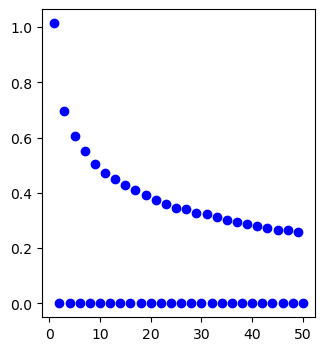

In [36]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "vgg19")

In [37]:
import numpy as np
from sklearn.metrics import classification_report

def prepare_for_test(model, test_gen):
    data, y_true = next(test_gen)  
    y_pred_ = model.predict(data, batch_size=64)  

    y_true_classes = np.argmax(y_true, axis=1)  
    
    y_pred_classes = np.argmax(y_pred_, axis=1)
    
    return y_true_classes, y_pred_classes

y_true, y_pred = prepare_for_test(model, test_gen)
print(classification_report(y_true, y_pred, target_names=['mild', 'moderate', 'normal', 'very-mild']))


100/100 ━━━━━━━━━━━━━━━━━━━━ 452s 5s/step
              precision    recall  f1-score   support

        mild       0.87      0.97      0.92       896
    moderate       1.00      1.00      1.00        64
      normal       0.91      0.92      0.92      3200
   very-mild       0.90      0.85      0.88      2240

    accuracy                           0.90      6400
   macro avg       0.92      0.94      0.93      6400
weighted avg       0.90      0.90      0.90      6400



In [39]:
# SAVE MODEL
model_dir = "./alzheimer_vgg19_model.h5" 
model.save(model_dir)                    
np.save('my_vgg19_history.npy', history.history)

# InceptionV3

In [41]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten

model = InceptionV3(input_shape=(176,176,3), weights='imagenet', include_top=False)

for layer in model.layers:
    layer.trainable = False

x = Flatten()(model.output)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


In [42]:
model = InceptionV3(input_shape=(176,176,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
x = Flatten()(model.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=model.input, outputs=prediction)

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 618s 8s/step - acc: 0.4223 - auc: 0.6627 - loss: 5.0407 - val_acc: 0.7010 - val_auc: 0.9137 - val_loss: 0.6991
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 428s 6s/step - acc: 0.7034 - auc: 0.9147 - loss: 0.7000 - val_acc: 0.6413 - val_auc: 0.8906 - val_loss: 0.9075
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 425s 5s/step - acc: 0.6719 - auc: 0.8971 - loss: 0.8810 - val_acc: 0.7722 - val_auc: 0.9441 - val_loss: 0.5673
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - acc: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 421s 5s/step - acc: 0.7940 - auc: 0.9552 - loss: 0.5007 - val_acc: 0.6304 - val_auc: 0.8923 - val_loss: 0.9472
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - acc: 0.0000e+00 - auc: 0.0000e+00

100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 814ms/step

 Model AUC 98.72%, Accuracy 89.81% on Test Data

              precision    recall  f1-score   support

        mild       0.78      0.99      0.87       896
    moderate       0.98      1.00      0.99        64
      normal       0.94      0.90      0.92      3200
   very-mild       0.90      0.86      0.88      2240

    accuracy                           0.90      6400
   macro avg       0.90      0.94      0.91      6400
weighted avg       0.90      0.90      0.90      6400



ValueError: x and y must have same first dimension, but have shapes (50,) and (25,)

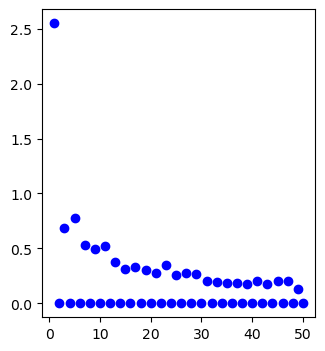

In [43]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, ['mild','moderate','normal','very-mild'], model_name = "inceptionv3")

In [44]:
import numpy as np
from sklearn.metrics import classification_report

def prepare_for_test(model, test_gen):
    data, y_true = next(test_gen)  
    y_pred_ = model.predict(data, batch_size=64)  
    
    y_true_classes = np.argmax(y_true, axis=1)  
    y_pred_classes = np.argmax(y_pred_, axis=1)
    
    return y_true_classes, y_pred_classes

y_true, y_pred = prepare_for_test(model, test_gen)
print(classification_report(y_true, y_pred, target_names=['mild', 'moderate', 'normal', 'very-mild']))


100/100 ━━━━━━━━━━━━━━━━━━━━ 85s 839ms/step
              precision    recall  f1-score   support

        mild       0.78      0.99      0.87       896
    moderate       0.98      1.00      0.99        64
      normal       0.94      0.90      0.92      3200
   very-mild       0.90      0.86      0.88      2240

    accuracy                           0.90      6400
   macro avg       0.90      0.94      0.91      6400
weighted avg       0.90      0.90      0.90      6400



In [45]:
model_dir = "./alzheimer_inceptionv3_model.h5"  
model.save(model_dir)                     
np.save('my_inceptionv3_history.npy', history.history)